In [2]:
%matplotlib inline

import os
import numpy as np
import cv2
from copy import deepcopy
from scipy import stats
from skimage import measure
import matplotlib.pyplot as plt
from utils.OverlayImage import  OverlayImage

In [3]:
orig_bf = 'path to HeLa/denoised/pos0/00059.png'
mask_matlab = 'path to matlab output /00059.png'

In [4]:
img_orig = cv2.imread(orig_bf, cv2.IMREAD_GRAYSCALE)
img_orig = img_orig[1200:,1000:1800]

Text(0.5, 1.0, 'Output after first stage')

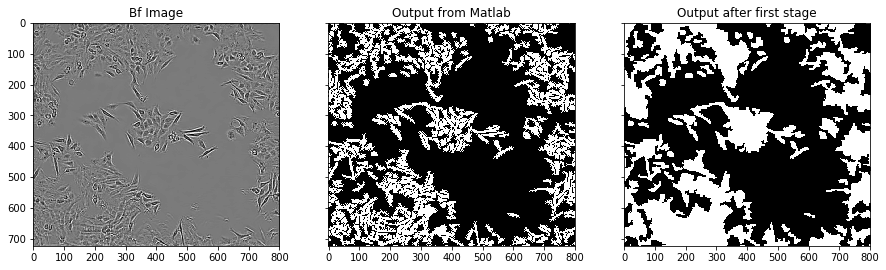

In [5]:
img_mask = cv2.imread(mask_matlab, cv2.IMREAD_GRAYSCALE)
img_mask[np.where(img_mask > 0)] = 255
img_mask = img_mask[:-20,:-20]
# For demonstration take only (1200:, 1000:2000)
img_mask = img_mask[1200:,1000:1800]

#FIRST STAGE
# dilation with (2,2) sphere
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
img_dilation = cv2.dilate(img_mask, kernel, iterations=1)
img_dilation = cv2.morphologyEx(img_dilation, cv2.MORPH_CLOSE, kernel)

# get the external contours and fill them up
contours_dilation, hierarchy = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
first_stage_mask = deepcopy(img_dilation)
cv2.drawContours(first_stage_mask, contours_dilation, -1, 255, -1)
first_stage_mask[np.where(first_stage_mask < 255)] = 0

# identify the small holes in the mask and fill them up
negate_mask = deepcopy(first_stage_mask)
negate_mask = 255 - negate_mask
contours_hole, hierarchy = cv2.findContours(negate_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
areas_hole = [[cv2.contourArea(contour)] for contour in contours_hole]
contours_area = zip(areas_hole, contours_hole)
contours_area = sorted(contours_area, key=lambda x: x[0], reverse=False)
small_hole = []
for (area, contour) in contours_area:
    if area[0] <= 500:
        small_hole.append(contour)

cv2.drawContours(first_stage_mask, small_hole, -1, 255, -1)
first_stage_mask = cv2.GaussianBlur(first_stage_mask, (3, 3), 0)
first_stage_mask[np.where(first_stage_mask < 255)] = 0


fig, axs = plt.subplots(1, 3, figsize=(15, 15), sharey=True)
axs[0].imshow(img_orig, cmap='gray')
axs[0].set_title('Bf Image')
axs[1].imshow(img_mask, cmap='gray')
axs[1].set_title('Output from Matlab')
axs[2].imshow(first_stage_mask, cmap='gray')
axs[2].set_title('Output after first stage')


Text(0.5, 1.0, 'Invert and pick >500')

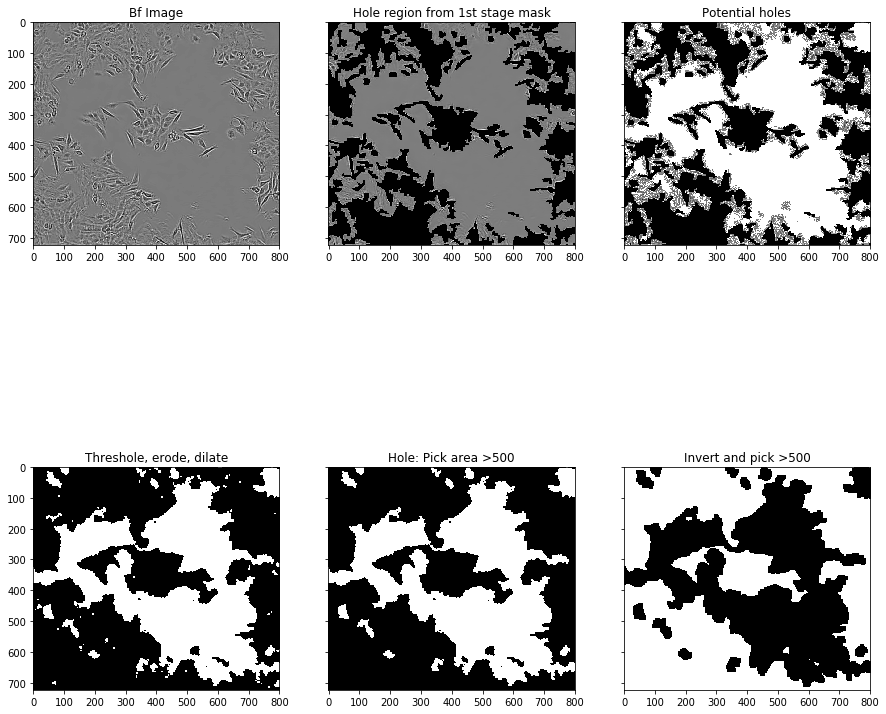

In [6]:
# SECOND STAGE
# Final mask from this stage didn't look good on crowded cases.
# We ignored the contrast differed region as interference pattern
# Following is done to fill holes

# Get the mode of the hole region using the original bright field image
hole_idx = np.where(first_stage_mask == 0)
cell_idx = np.where(first_stage_mask == 255)

# img_edit will be used to precisely find the hole region
img_edit = deepcopy(img_orig)

img_edit[cell_idx] = 0
holes = img_edit[hole_idx]
holes_mode = stats.mode(holes).mode[0]

plot_2 = deepcopy(img_edit)

# Fill mode +5, -5 as potential holes in img_edit
for id in range(holes_mode - 5, holes_mode + 6):
    img_edit[np.where(img_edit == id)] = 255

plot_3 = deepcopy(img_edit)

img_edit[np.where(img_edit < 250)] = 0
img_edit[np.where(img_edit >= 250)] = 255

# erode and dilate to fill tiny holes
img_edit = cv2.erode(img_edit, None, iterations=2)
img_edit = cv2.dilate(img_edit, None, iterations=2)

plot_4 = deepcopy(img_edit)

# Identify connected components and consider only the ones with >500 px as holes
labels = measure.label(img_edit, neighbors=8, background=0)
mask = np.zeros(img_edit.shape, dtype="uint8")

# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue

    # otherwise, construct the label mask and count the
    # number of pixels
    labelMask = np.zeros(img_edit.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)

    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 500:
        mask = cv2.add(mask, labelMask)

plot_5 = deepcopy(mask)

# mask from above has white px for the hole region
# so negate it to get the cell covered region
mask = 255 - mask

# Now identify the connected components >500 px
# to ensure some small darks spots which are not actually cells are neglected
labels_final_mask = measure.label(mask, neighbors=8, background=0)
final_mask = np.zeros(mask.shape, dtype="uint8")

# loop over the unique components
for label in np.unique(labels_final_mask):
    # if this is the background label, ignore it
    if label == 0:
        continue

    # otherwise, construct the label mask and count the
    # number of pixels
    labelMask = np.zeros(final_mask.shape, dtype="uint8")
    labelMask[labels_final_mask == label] = 255
    numPixels = cv2.countNonZero(labelMask)

    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 500:
        final_mask = cv2.add(final_mask, labelMask)

final_mask = cv2.erode(final_mask, None, iterations=3)

fig, axs = plt.subplots(2, 3, figsize=(15, 15), sharey=True)
axs[0][0].imshow(img_orig, cmap='gray')
axs[0][0].set_title('Bf Image')
axs[0][1].imshow(plot_2, cmap='gray')
axs[0][1].set_title('Hole region from 1st stage mask')
axs[0][2].imshow(plot_3, cmap='gray')
axs[0][2].set_title('Potential holes')
axs[1][0].imshow(plot_4, cmap='gray')
axs[1][0].set_title('Threshole, erode, dilate')
axs[1][1].imshow(plot_5, cmap='gray')
axs[1][1].set_title('Hole: Pick area >500')
axs[1][2].imshow(final_mask, cmap='gray')
axs[1][2].set_title('Invert, pick >500, erode')


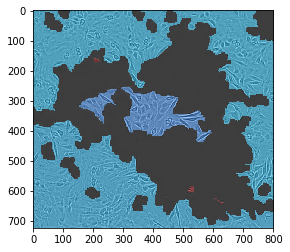

In [7]:
transparancylevel = 0.5
img_orig_ = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2RGB)
overlay = OverlayImage().compOverlayImage(img_orig_, final_mask, transparancylevel)

plt.figure()
plt.imshow(overlay, cmap='gray')